# Introduction to Unsupervised Learning with a Focus on PCA

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F2_unsupervised_learning.ipynb)

<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>
    
- Fundamentals of linear algebra (eigendecomposition, orthogonal matrices, orthogonal projection)
- Fundamentals in statistics (covariance matrix, sample estimates)
</div>

<div class="alert alert-block alert-info">
    <b>Learning Outcomes</b>
    
- Define an unsupervised learning problem
- Explain the curse of dimensionality
- State the objectives of Principal Component Analysis (PCA) in terms of variance maximization and best approximation
- Decompose the sample covariance matrix into eigenvectors and eigenvalues to solve a PCA problem.
</div>

## Unsupervised learning objective

Contrary to supervised learning, we only have:

- an *input* vector $\boldsymbol{X}$ of $X_1, \ldots, X_p$ input variables with a joint probability distribution $\mathbb{P}(\boldsymbol{X})$.

<hr>

**Supervised Learning Objective**
<br>
Directly infer some properties of $\mathbb{P}(\boldsymbol{X})$ from observations $\boldsymbol{x}_i, i = 1, \ldots N$. 

<hr>

- The dimension $p$ is usually large $\rightarrow$ not possible to directly estimate $\mathbb{P}(\boldsymbol{X})$ (e.g. histogram),
- and there is no direct measure of success,
- but we are not interested in learning how the distribution changes depending (conditioned) on some other variable.

### Example: Detecting patterns of SST variability, reduce, predict

<img src="images/2014_tantet_dijkstra_sst_community.png" width=800>

**Figure:** 10 communities from a network constructed from the sample correlation matrix of 140 years of gridded monthly Sea Surface Temperature (SST) observations. Each grid point is a node in the network to which we assign the color of its community (Tantet and Dijkstra 2014).

### Curse of dimensionality

Often, the average number of observations $N$ required to capture some structure with a given level of accuracy increases exponentially with the dimension $p$.

For instance, the following example illustrates that, to achieve the same sampling density $\rho$ in a unit hypercube, we must have $N = \rho^p$.

In [1]:
# Imports and configuration for this tutorial
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import holoviews as hv
import hvplot.pandas
import panel as pn
pn.extension()

# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Quiver configuration
KWARGS_QUIVER = dict(units='xy', angles='xy', scale_units='xy', scale=1.)

# Matplotlib configuration
plt.rc('font', size=14)

Text(0.5, 0.92, 'p = 3, density = 10, N = 1000')

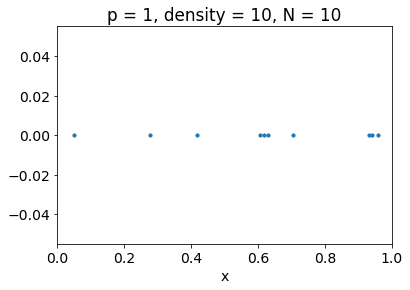

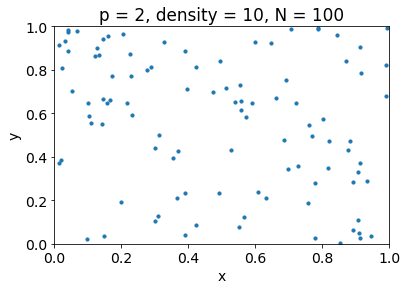

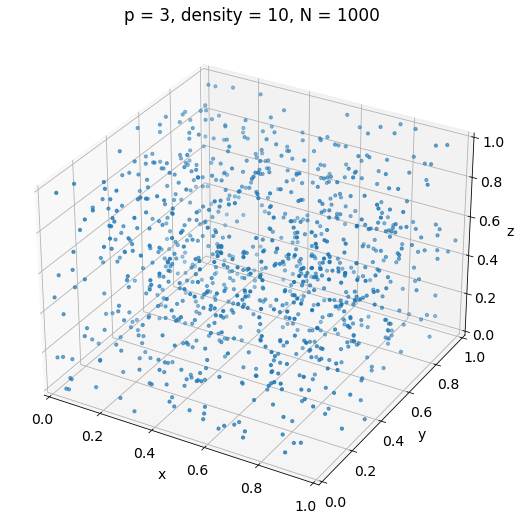

In [2]:
# Number of points per unit hypercube
density = 10

# Get as many observations drawn from a uniform distribution
# as needed to get the given density for of hypercube of dimension p
def get_observations(p, density):
    return np.random.rand(density**p, p)

# Plot configuration
xlim = [0, 1]
markersize = 10

# Plot observations for 1 dimension
p = 1
X = get_observations(p, density)
plt.figure()
plt.scatter(X, np.zeros(X.shape), s=markersize)
plt.xlabel('x')
plt.xlim(xlim)
plt.title('p = {}, density = {}, N = {}'.format(
    p, density, X.shape[0]))

# Plot observations for 2 dimensions
p = 2
X = get_observations(p, density)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=markersize)
plt.xlabel('x')
plt.xlim(xlim)
plt.ylabel('y')
plt.ylim(xlim)
plt.title('p = {}, density = {}, N = {}'.format(
    p, density, X.shape[0]))

# Plot observations for 3 dimensions
p = 3
X = get_observations(p, density)
fig = plt.figure(figsize=[12, 9])
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=markersize)
ax.set_xlabel('x')
ax.set_xlim(xlim)
ax.set_ylabel('y')
ax.set_ylim(xlim)
ax.set_zlabel('z')
ax.set_zlim(xlim)
plt.title('p = {}, density = {}, N = {}'.format(
    p, density, X.shape[0]))

## Applications

- Dimension reduction/feature selection/pattern identification (PCA, multidim. scaling, self-organizing maps, principal curves, ...):
  - identify low-dimensional hypersurfaces (manifolds) in $\boldsymbol{X}$-space
  - provide information about associations among variables
  - express input variables as functions of a smaller set of "latent"/"hidden" variables
- Identify modes (local maxima) of $\mathbb{P}(\boldsymbol{X})$ (cluster analysis, mixture modeling)


## Principal Component Analysis (PCA)

Different ways to look at the objective:
- *Linearly* combine variables into $q < p$ new variables which are mutually uncorrelated and explain as much variance as possible
- Find an orthogonal basis of $\mathbb{R}^p$ such that the projection of the data on the leading $q$ basis vectors explain as much variance as possible
- Find a family of $q$ vectors such that the projection of the data on the linear space spanned by these vectors best approximate the original data for the squared error.

- The following example illustrates these last two points for two-dimensional data in the `(x, y)` plane drawn from a correlated multivariate normal distribution.

- The angle gives the direction of the vector generating the blue line.

- The orange points are the projection of the gray points on the line.

- The variance of the projected data and the mean Euclidean distance squared between the original data and the projection are given in the title.

- In 2D, there is no freedom in choosing the direction of a second vector orthogonal to the first.

> ***Question***
> - Use the widget below to find the angle that maximizes the variance of the projected data.
> - Compare the angle that minimizes the distance between the original data and its projection to the previous one.
> - If you are asked to predict a 3rd variable `z` with a single variable, but you do not know the relationship between `z` and `x` and `y`, which combination of `x` and `y` to predict `z`.

Column
    [0] Column
        [0] DiscreteSlider(formatter='%d', name='angle', options=[0, 1, 2, 3, 4, ...], value=0)
    [1] Row
        [0] Row
            [0] Matplotlib(Figure)
            [1] HoloViews(Distribution)
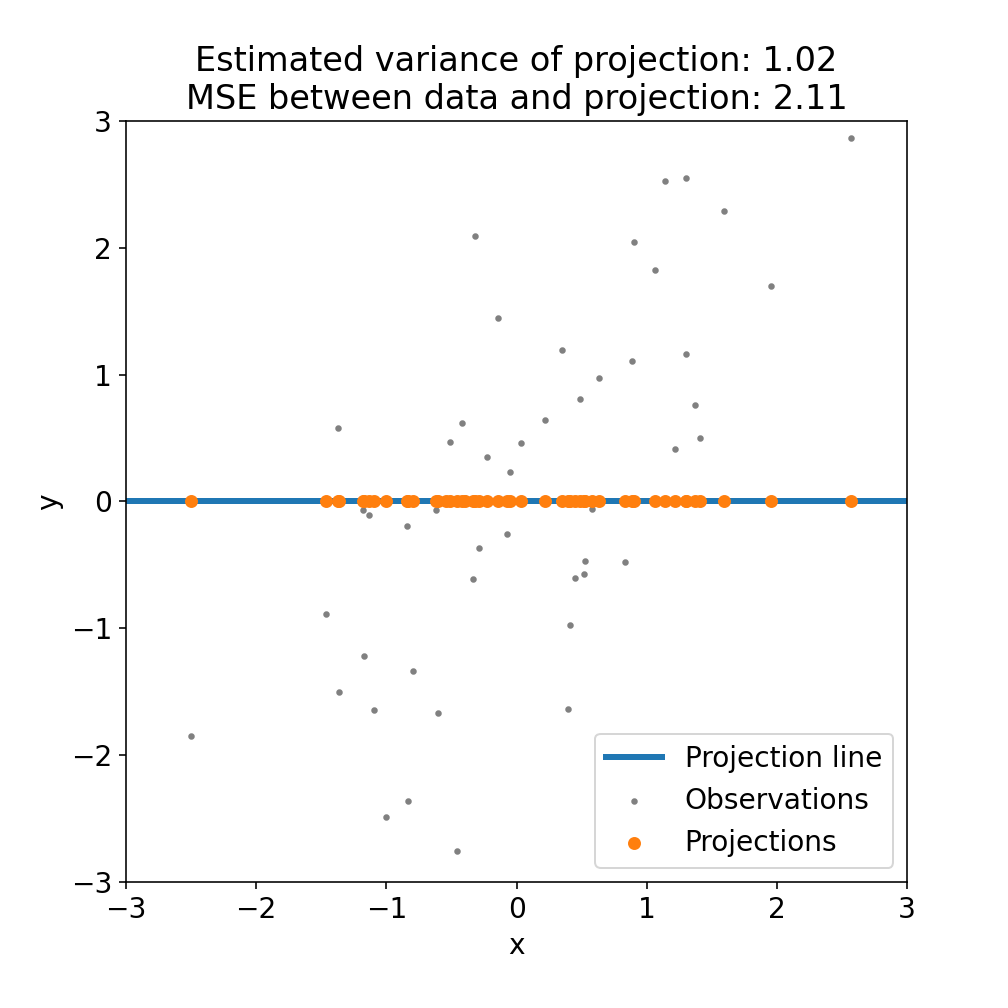

In [7]:
p = 2
xlim = [-3, 3]

# True mean vector and covariance matrix
mean_true = np.zeros((p,))
var_x = 1.
var_y = 2.
corr_xy = 0.75
cov_xy = corr_xy * np.sqrt(var_x * var_y)
cov_true = np.array([[var_x, cov_xy], [cov_xy, var_y]])


# Generate train data from multivariate normal distribution
N = 50
X_train = np.random.multivariate_normal(mean_true, cov_true, size=N)

# Plot projection of observations on line
def plot_projection(angle):
    # Get line for angle
    x_line = np.linspace(*xlim, 100)
    beta = np.tan(np.deg2rad(angle))
    y_line = beta * x_line
    
    # Compute variance of projection
    v = np.array([1., beta])
    v /= np.linalg.norm(v)
    A = X_train @  v
    var_proj = A.var()
    
    # Get orthogonal projection of train data on vector
    X_trunc = np.array([A * v[i] for i in range(len(v))]).T
    mse = ((X_train - X_trunc)**2).sum(1).mean()

    fig = Figure(figsize=[7, 7])
    ax = fig.subplots()
    ax.set_xlim(xlim)
    ax.set_xlabel('x')
    ax.set_ylim(xlim)
    ax.set_ylabel('y')

    # Plot train data
    ax.scatter(*X_train.T, s=5, c='0.5', label='Observations')

    # Plot line for angle
    ax.plot(x_line, y_line, lw=3, label='Projection line')

    # Plot orthogonal projection of train data on vector
    ax.scatter(*X_trunc.T, s=30, c=RC_COLORS[1], label='Projections',
               zorder=3)
    
    # Show variance of projection in title
    ax.set_title('Estimated variance of projection: {:.2f}\n'
                 'MSE between data and projection: {:.2f}'.format(
                     var_proj, mse))
    ax.legend(loc='lower right')
    
    # Plot kernel density estimate of projected data
    As = pd.Series(A)
    As.name = 'Components of observations on vector'
    pkde = As.hvplot.kde(xlim=xlim, ylim=[0., 0.8], width=400)
    
    return pn.Row(pn.pane.Matplotlib(fig), pkde)

pn.interact(plot_projection, angle=np.arange(0, 181))

### Mathematical formulation

#### As an approximation problem

Find a $q$-dimensional space with $q < p$ and an associated dataset such the MSE between the datasets is minimized:

\begin{equation}
    \mathrm{min}_{\boldsymbol{\mu}, \mathbf{A}, \mathbf{V}_q} \sum_{i = 1}^N \|\boldsymbol{x}_i - \boldsymbol{\mu} - \boldsymbol{a}_i^\top \mathbf{V}_q^\top  \|^2.
\end{equation}

- $\boldsymbol{\mu}$ is a $p$-dimensional *location* vector
- $\mathbf{V}_q$ is a $p \times q$ matrix with $q$ orthogonal unit vectors as columns with elements giving their components in the original $\mathbb{R}^p$ space
- $\mathbf{A}_q$ is a $N \times q$ matrix such that its rows $\boldsymbol{a}_i, 1 \le i \le N$ give the components of the observation $\boldsymbol{x}_i$ in the space spanned by the columns of $\mathbf{V}_q$.

> ***Question (optional)***
> - Show that, given the orthonormal matrix $\mathbf{V}_q$, the optimal values of $\boldsymbol{\mu}$ and $\boldsymbol{a}_i, 1 \le i \le N$ are given by the following formulas.

\begin{align}
    \hat{\boldsymbol{\mu}} &= \bar{\boldsymbol{x}} \\
    \hat{\boldsymbol{a}}_i^\top &= (\boldsymbol{x}_i - \bar{\boldsymbol{x}})^\top \mathbf{V}_q.
\end{align}


The minimization problem is then equivalent to

\begin{equation}
    \mathrm{min}_{\mathbf{V}_q} \sum_{i = 1}^N
    \left(\boldsymbol{x}_i - \bar{\boldsymbol{x}} - (\boldsymbol{x}_i - \bar{\boldsymbol{x}})^\top \mathbf{V}_q \mathbf{V}_q^\top  \right)^\top
    \left(\boldsymbol{x}_i - \bar{\boldsymbol{x}} - (\boldsymbol{x}_i - \bar{\boldsymbol{x}})^\top \mathbf{V}_q \mathbf{V}_q^\top  \right),
\end{equation}

subject to $\mathbf{V}_q$ being an orthonormal matrix.

#### As a variance problem

> ***Question (optional)***
> - Show that the above problem is in turn equivalent to the problem below.
> - Interpret the formulation below in terms of variance.

\begin{equation}
        \mathrm{max}_{\mathbf{V}_q} \sum_{k = 1}^p \left[\mathbf{V}_q^\top \mathbf{\Sigma} \mathbf{V}_q\right]_{kk}
\end{equation}

subject to  $\mathbf{V}_q$ being an orthonormal matrix and with $\mathbf{\Sigma}$ the covariance matrix of $\mathbf{X}$.

### Solution

#### First vector $\boldsymbol{v}_1$

We want to maximize $\boldsymbol{v}_1^\top \mathbf{\Sigma} \boldsymbol{v}_1$ such that $\boldsymbol{v}_1^\top \boldsymbol{v}_1 = 1$ (unit vector).

This is an equality-constrained optimization equivalent to

\begin{equation}
    \mathrm{max}_{\boldsymbol{v}_1} \ \ \boldsymbol{v}_1^\top \mathbf{\Sigma} \boldsymbol{v}_1 - \lambda_1 (\boldsymbol{v}_1^\top \boldsymbol{v}_1 - 1),
\end{equation}

where $\lambda$ is the Legendre multiplier associated with the constraint.

> ***Question (optional)***
> - Show that the optimal vector $\boldsymbol{v}_1$ is the eigenvector of the covariance matrix $\mathbf{\Sigma}$ associated with the largest eigenvalue, itself giving the Lagrange multiplier $\lambda_1$.

#### Second vector $\boldsymbol{v}_2$

We want to maximize $\boldsymbol{v}_2^\top \mathbf{\Sigma} \boldsymbol{v}_2$ such that $\boldsymbol{v}_2^\top \boldsymbol{v}_2 = 1$ and $\boldsymbol{v}_1^\top \boldsymbol{v}_2 = 0$ (orthogonality).

This is equivalent to

\begin{equation}
    \mathrm{max}_{\boldsymbol{v}_2} \ \ \boldsymbol{v}_2^\top \mathbf{\Sigma} \boldsymbol{v}_2 - \lambda_2 (\boldsymbol{v}_2^\top \boldsymbol{v}_2 - 1) - \lambda_{12} (\boldsymbol{v}_1^\top \boldsymbol{v}_2 - 0).
\end{equation}

> ***Question (optional)***
> - Show that the optimal vector $\boldsymbol{v}_2$ is the eigenvector of the covariance matrix $\mathbf{\Sigma}$ associated with the second largest eigenvalue, itself giving the Lagrange multiplier $\lambda_2$.

If we iterate this process up to $q \le p$, we get that $\mathbf{V}_q$ is such that

\begin{equation}
\mathbf{\Sigma} \mathbf{V}_q = \mathbf{V}_q \mathbf{\Lambda}_q,
\end{equation}

where $\Lambda_q$ is a (rectangular) diagonal matrix.

- The column vectors of $\mathbf{V}_q$ computed based on an estimate of the covariance matrix are sometimes called the *Empirical Orthogonal Functions (EOFs)* of the data $\mathbf{X}$.
- The columns of $\mathbf{A}_q = \mathbf{X} \mathbf{V}_q$ are called the *principal components* of $\mathbf{X}$. The $i$th row of $\mathbf{A}_q$ gives the components in the space spanned by $\mathbf{V}_q$ of the observation $\boldsymbol{x}_i$.

> ***Question***
> - Show that the variance of the $k$th principal component is $\lambda_k$ and that the covariance between the $k$th and the $l$th principal components, $k \ne l$, is zero.
> - How much variance of the original dataset is explained by the first $q$ principal components?
> - Show that, when $q = p$, the original data matrix $\mathbf{X}$ can be reconstructed from the principal components matrix $\mathbf{A} := \mathbf{A}_p$ given the EOFs $\mathbf{V} := \mathbf{V}_p$.

### PCA application to a multivariate normal distribution

The following two-dimensional example illustrates how, in the case of a multivariate normal distribution, the principal vectors generate the principal axes of the ellipsoids giving the contours of the density.

Here, the true covariance matrix is known (`cov_true`), so that the principal vectors can be directly computed by solving the eigenvalue problem for the true covariance matrix using `np.linalg.eigh`.

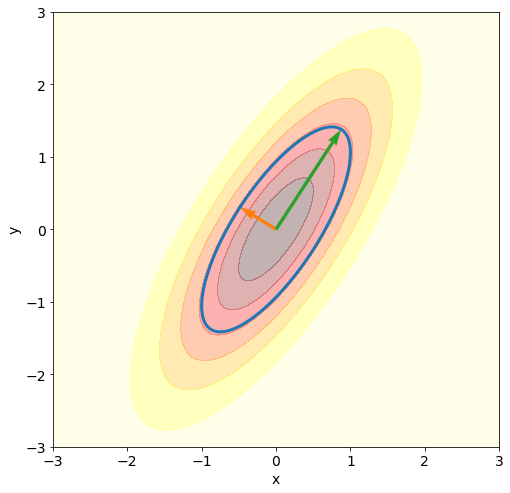

In [4]:
p = 2
xlim = [-3, 3]

# True mean vector and covariance matrix
mean_true = np.zeros((p,))
var_x = 1.
var_y = 2.
corr_xy = 0.75
cov_xy = corr_xy * np.sqrt(var_x * var_y)
cov_true = np.array([[var_x, cov_xy], [cov_xy, var_y]])

# Numerical approximation of eigenvectors and eigenvalues of covariance matrix
lambda_true, V_true = np.linalg.eigh(cov_true)
Lambda_true = np.diag(lambda_true)
VD_true = V_true @ np.sqrt(Lambda_true)

# Distribute points uniformely on ellipse
t = np.linspace(0, 2 * np.pi, 100)
A_ellipse = np.array([np.cos(t), np.sin(t)]).T
X_ellipse = A_ellipse @ VD_true.T

# Get PDF values of multivariate normal distribution on grid using known
# formulas
rv = stats.multivariate_normal(mean_true, cov_true)
slice_grid = slice(*xlim, 0.01)
x_grid, y_grid = np.mgrid[slice_grid, slice_grid]
xy_grid = np.dstack((x_grid, y_grid))
pdf = rv.pdf(xy_grid)

# Plot
plt.figure(figsize=[8, 8])
plt.xlim(xlim)
plt.ylim(xlim)
plt.xlabel('x')
plt.ylabel('y')

# Plot PDF contours
plt.contourf(x_grid, y_grid, pdf, cmap='hot_r', alpha=0.3)

# Plot ellipse with principal axes given by eigenvectors scaled by eigenvalues
plt.plot(*X_ellipse.T, lw=3)

# Plot true eigenvectors scaled by eigenvalues
plt.quiver(mean_true, mean_true, VD_true[0], VD_true[1], color=RC_COLORS[1:3],
           **KWARGS_QUIVER)

### PCA application to non-Gaussian 

Most often, the true covariance matrix is not known.

The principal vectors can be estimated by EOFs, i.e. the eigenvectors of the sample covariance matrix.

This is illustrated below, where the EOFs are compared to the true principal vectors, for a varying sample size `N`.

In this case, nonlinear versions of PCA may be more appropriate although not as simple to apply.

Column
    [0] Column
        [0] Button(button_type='primary', name='Resample')
        [1] DiscreteSlider(formatter='%d', name='N', options=[5, 10, 15, 20, ...], value=5)
    [1] Row
        [0] Matplotlib(Figure)
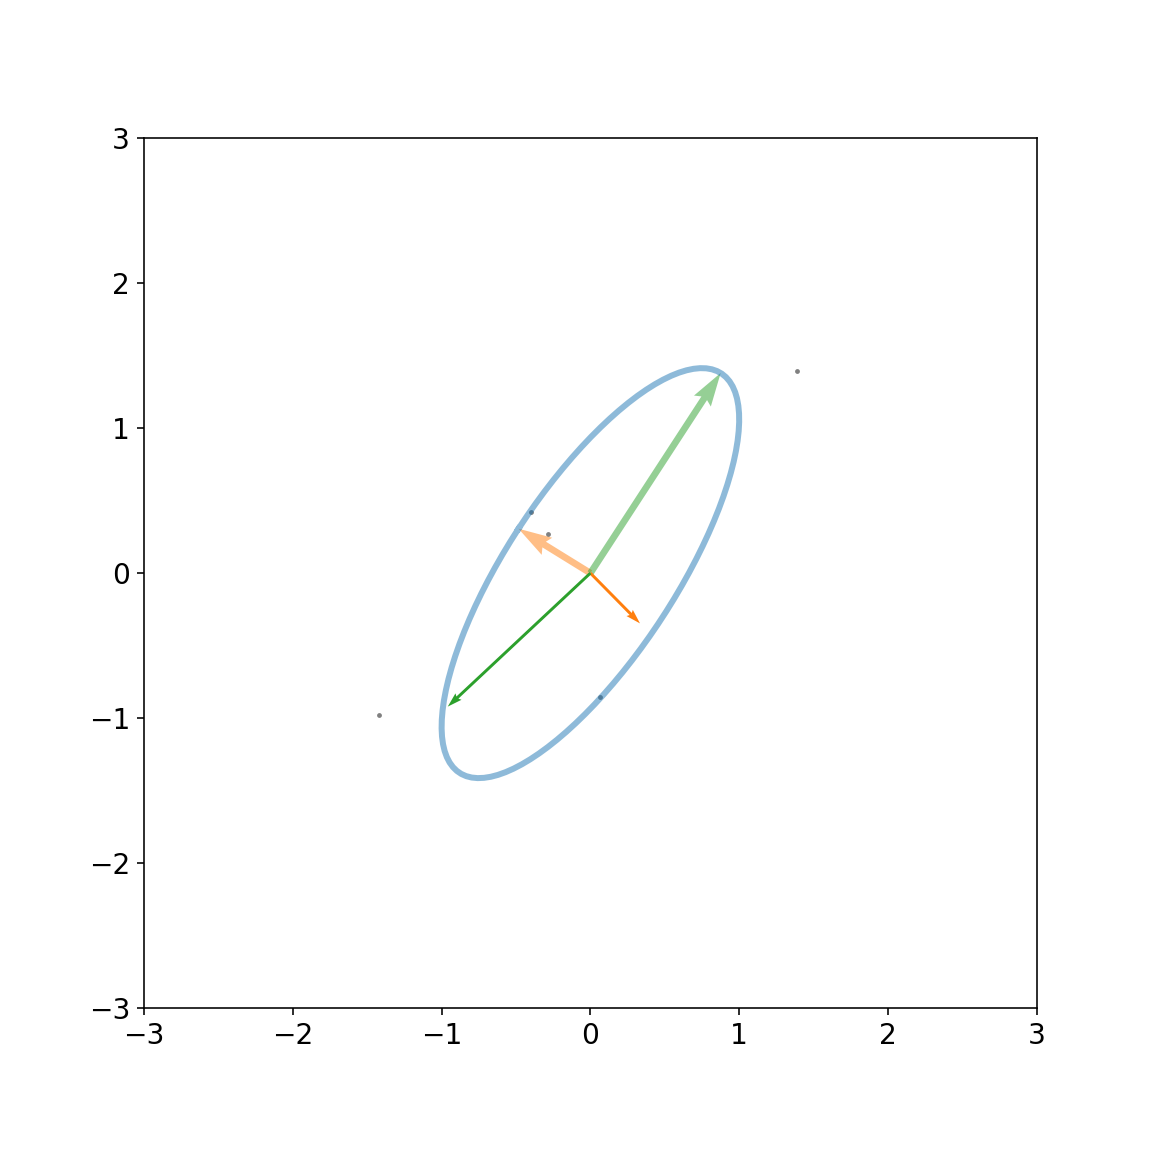

In [5]:
# Plot EOF estimated from a sample of N observations
def plot_eof(b, N=5):
    # Generate train data from multivariate normal distribution
    X_train = np.random.multivariate_normal(mean_true, cov_true, size=N)

    # Estimate covariance matrix from train data
    cov_train = np.cov(X_train.T)

    # Get EOFs
    lambda_train, V_train = np.linalg.eigh(cov_train)
    Lambda_train = np.diag(lambda_train)
    VD_train = V_train @ np.sqrt(Lambda_train)

    fig = Figure(figsize=[8, 8])
    ax = fig.subplots()
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)

    # Plot train data
    ax.scatter(*X_train.T, s=2, c='0.5')

    # Plot ellipse with principal axes given by eigenvectors scaled by eigenvalues
    ax.plot(*X_ellipse.T, alpha=0.5, lw=3)

    # Plot true eigenvectors scaled by eigenvalues
    ax.quiver(mean_true, mean_true, VD_true[0], VD_true[1],
              color=RC_COLORS[1:3], alpha=0.5, **KWARGS_QUIVER)

    # Plot EOFs scaled by eigenvalue estimates
    ax.quiver(mean_true, mean_true, VD_train[0], VD_train[1],
              color=RC_COLORS[1:3], width=0.02, **KWARGS_QUIVER)
    
    return pn.pane.Matplotlib(fig)

button = pn.widgets.Button(name='Resample', button_type='primary')
pn.interact(plot_eof, b=button, N=np.arange(5, 510, 5))

In most cases, the true probability distribution is not parameterizable by the covariance matrix.

For instance, a nonlinear relationship may exist between the input variables.

This is illustrated in the following two-dimensional example where the EOFs are estimated from a dataset where the second variable is a noisy perturbation of a monomial of the first variable whose degree is controlled by `degree`.

Column
    [0] Column
        [0] Button(button_type='primary', name='Resample')
        [1] DiscreteSlider(formatter='%d', name='N', options=[10, 20, 30, 40, ...], value=100)
        [2] IntSlider(end=6, name='degree', start=-2, value=2)
    [1] Row
        [0] Matplotlib(Figure)
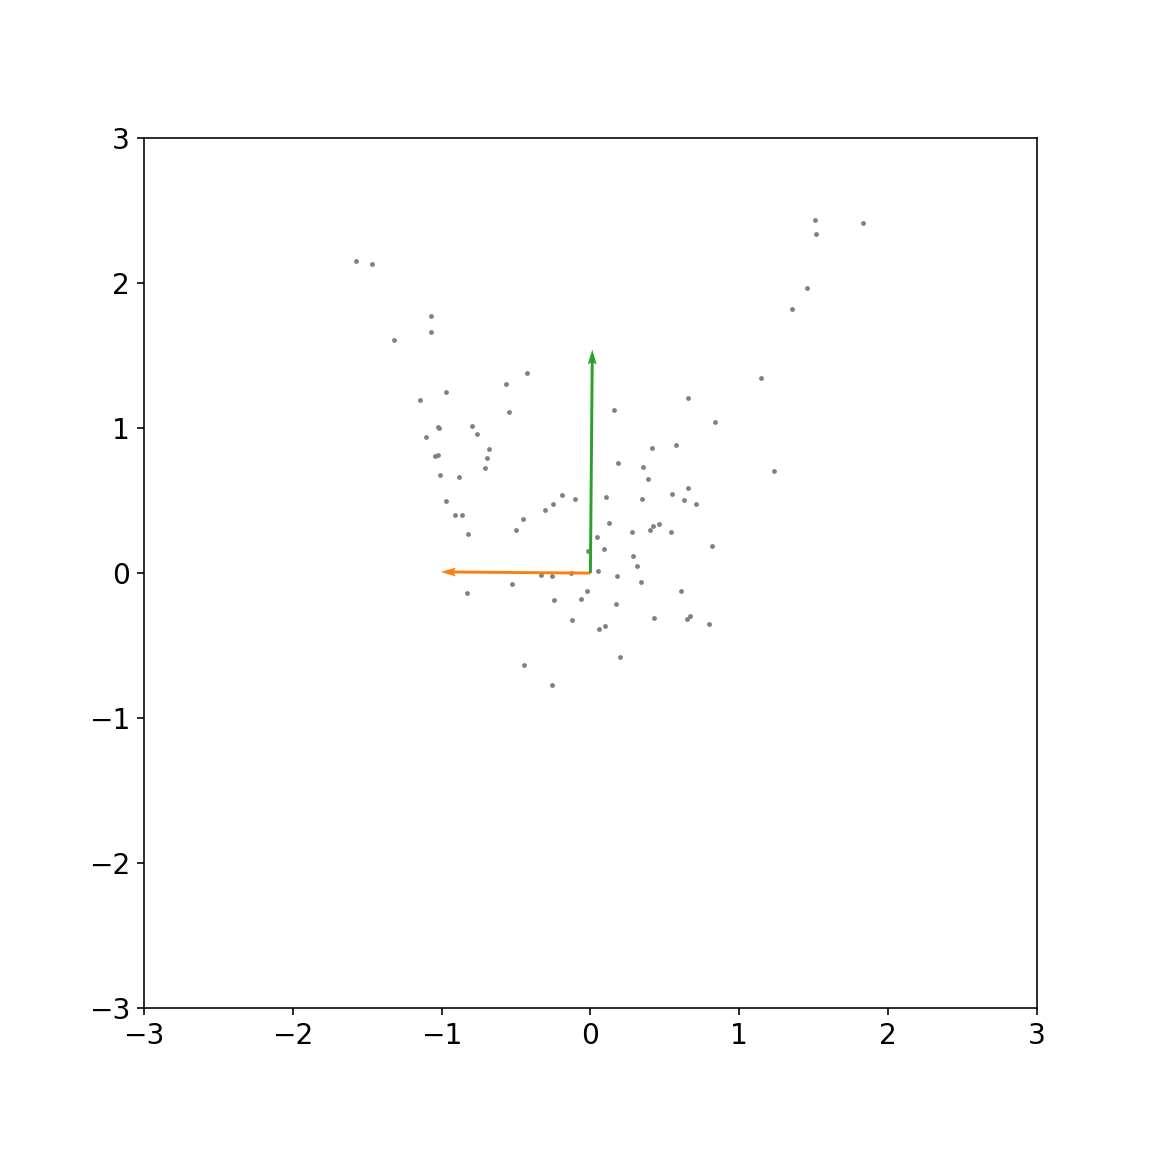

In [6]:
# Plot EOF estimated from a sample of N observations
def plot_eof(b, N=100, degree=2):
    # Generate train data from multivariate normal distribution
    x_train = np.random.randn(N)
    y_train = x_train**degree + np.random.randn(N) * 0.5
    X_train = np.array([x_train, y_train]).T

    # Estimate covariance matrix from train data
    cov_train = np.cov(X_train.T)

    # Get EOFs
    lambda_train, V_train = np.linalg.eigh(cov_train)
    Lambda_train = np.diag(lambda_train)
    VD_train = V_train @ np.sqrt(Lambda_train)

    fig = Figure(figsize=[8, 8])
    ax = fig.subplots()
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)

    # Plot train data
    ax.scatter(*X_train.T, s=2, c='0.5')

    # Plot EOFs scaled by eigenvalue estimates
    ax.quiver(mean_true, mean_true, VD_train[0], VD_train[1],
              color=RC_COLORS[1:3], width=0.02, **KWARGS_QUIVER)
    
    return pn.pane.Matplotlib(fig)

button = pn.widgets.Button(name='Resample', button_type='primary')
pn.interact(plot_eof, b=button, N=np.arange(10, 510, 10))

### PCA as a Singular Value Decomposition (SVD) (optional)

The *SVD* of $\mathbf{X}$ is such that,

\begin{equation}
    \mathbf{X} = \mathbf{U} \mathbf{D} \mathbf{V}^\top,
\end{equation}

- $\mathbf{U}$ is an $N \times p$ orthogonal matrix ($\mathbf{U}^\top \mathbf{U} = \mathbf{I}_p$) whose columns are called the *left singular vectors*
- $\mathbf{V}$ is a $p \times p$ orthogonal matrix ($\mathbf{V}^\top \mathbf{V} = \mathbf{I}_p$) whose columns are called the *right singular vectors*
- $\mathbf{D}$ is a $p \times p$ diagonal matrix with elements $d_1 \le d_2 \le \ldots \le d_p \le 0$ known as the *singular values*.

> ***Question (optional)***
> - Show that we have the following correspondence between the eigendecomposition of $\mathbf{\Sigma}$ and the SVD of $\mathbf{X}$.

- EOFs are right singular vectors $\mathbf{V}$
- Eigenvalues are proportional to singular values squared: $\mathbf{\Lambda} = \mathbf{D}^2 / (N - 1)$
- Principal components: $\mathbf{A} := \mathbf{X} \mathbf{V} = \mathbf{U} \mathbf{D}$
- Left singular vectors $\mathbf{U}$ are eigenvectors of $\mathbf{X} \mathbf{X}^\top$

## To go further

- Nonlinear PCA
- Cluster analysis
- Reduction for OLS: Partial Least Squares, Canonical Correlation Analysis, Reduced Rank Regression

## References

- Chap. 14 in [Hastie, T., Tibshirani, R., Friedman, J., 2009. *The Elements of Statistical Learning*, 2nd ed. Springer, New York.](https://doi.org/10.1007/978-0-387-84858-7)
- Chap. 13 and 14 in [Wilks, D.S., 2019. *Statistical Methods in the Atmospheric Sciences*, 4th ed. Elsevier, Amsterdam.](https://doi.org/10.1016/C2017-0-03921-6)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>